In [1]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [2]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class MyGabor(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        self.sigma_x = nn.Parameter(kernel_size[0]/3*torch.rand(in_channels,out_channels))
        self.sigma_y = nn.Parameter(kernel_size[0]/3*torch.rand(in_channels,out_channels))
        self.freq = nn.Parameter(kernel_size[0]*torch.rand(in_channels,out_channels))
        self.theta = nn.Parameter(3.14*torch.rand(in_channels,out_channels))
        self.psi = nn.Parameter(3.14*torch.rand(in_channels,out_channels))
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        
        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]
        y, x = torch.meshgrid([torch.arange(-y0+1,y0), torch.arange(-x0+1,x0)])
        x = x.to(device)
        y = y.to(device)
        weight = torch.empty(self.weight.shape, requires_grad=False).to(device)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                sigma_x = self.sigma_x[i,j].expand_as(y)
                sigma_y = self.sigma_y[i,j].expand_as(y)
                freq = self.freq[i,j].expand_as(y)
                theta = self.theta[i,j].expand_as(y)
                psi = self.psi[i,j].expand_as(y)
                
                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta) 
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * rotx + psi) #/ (2*3.14*sigma_x*sigma_y + 1e-3)
                weight[j,i] = g
                self.weight.data[j,i] = g    
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [3]:
import os
from random import choice
from PIL import Image
import numpy as np

class DatasetLoader():
    def __init__(self, source_path = 'D:\!EMONEW_cropped', classes = 7, train = 0.66):
        self.source_path = os.path.normpath(source_path)
        self.data = []
        self.test_data = []
        self.num_classes = classes
        self.train = train
        
        for path in os.listdir(path=source_path):
            source_path = os.path.join(self.source_path, path)
            if os.path.isdir(source_path):
                classes = classes - 1
                target = [0]*self.num_classes
                target[classes] = 1
                self._list_to_jpeg(source_path, target)
            
    def _list_to_jpeg(self, path, target):
        for i in os.walk(path):
            for j in i[2]:
                if '.jpg' in j or '.png' in j:
                    if np.random.rand() <= self.train:
                        self.data.append([[os.path.join(i[0], j)], target])
                    else:
                        self.test_data.append([[os.path.join(i[0], j)], target])
    def get_batch(self, len_batch, train = True, keras_style = False):
        batch_data = []
        batch_target = []
        if keras_style:
            transpose = (0,1,2)
        else:
            transpose = (2,0,1)
        
        for i in range(len_batch):
            if train == True:
                d, t = choice(self.data)
            else:
                d, t = choice(self.test_data)
            batch_target.append(t)
            batch_data.append(np.asarray(Image.open(d[0])).transpose(transpose))
        return np.array(batch_data), np.array(batch_target)
    
    def lenght(self, train = True):
        if train == True:
            return len(self.data)
        else:
            return len(self.test_data)

## CHECK DATALOADER

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.g1 = MyGabor(3, 32, kernel_size=(15,15), stride=2)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=2)
        self.c2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.g1(x))
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = Net().to(device)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
EMONEW = DatasetLoader()

cuda:0
Net(
  (g1): MyGabor(3, 32, kernel_size=(15, 15), stride=(2, 2), bias=False)
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [6]:
net(torch.rand(1,3,309,287, device=device))

tensor([[-0.2944, -0.2979, -0.2751, -0.2396, -0.0459, -0.1190, -0.0899]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)

In [7]:
BATCH_SIZE = 64

gabor_test_acc = []

for epoch in range(250):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(int(EMONEW.lenght()/BATCH_SIZE)):
        net.train()
        # get the inputs
        inputs, labels = EMONEW.get_batch(BATCH_SIZE)
        inputs = torch.Tensor(inputs).to(device)/255
        labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # print statistics
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d] loss: %.3f' %(epoch + 1, running_loss / (20*BATCH_SIZE)))
            running_loss = 0.0
            
        optimizer.step()
        
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i in range(int(EMONEW.lenght(False)/BATCH_SIZE)):
            inputs, labels = EMONEW.get_batch(BATCH_SIZE, False)
            inputs = torch.Tensor(inputs).to(device)/255
            outputs = net(inputs)
            labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
            test_loss += criterion(outputs, labels) # sum up batch loss
            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= EMONEW.lenght(False)
    print('\n[{}] Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch+1,
        test_loss, correct, EMONEW.lenght(False),
        100. * correct / EMONEW.lenght(False)))
    gabor_test_acc.append(correct / EMONEW.lenght(False))
print('Finished Training')


[1] Test set: Average loss: 0.0283, Accuracy: 241/1077 (22%)


[2] Test set: Average loss: 0.0229, Accuracy: 394/1077 (37%)


[3] Test set: Average loss: 0.0196, Accuracy: 483/1077 (45%)


[4] Test set: Average loss: 0.0183, Accuracy: 518/1077 (48%)


[5] Test set: Average loss: 0.0177, Accuracy: 545/1077 (51%)


[6] Test set: Average loss: 0.0170, Accuracy: 590/1077 (55%)


[7] Test set: Average loss: 0.0161, Accuracy: 595/1077 (55%)


[8] Test set: Average loss: 0.0159, Accuracy: 600/1077 (56%)


[9] Test set: Average loss: 0.0160, Accuracy: 594/1077 (55%)


[10] Test set: Average loss: 0.0150, Accuracy: 617/1077 (57%)


[11] Test set: Average loss: 0.0172, Accuracy: 629/1077 (58%)


[12] Test set: Average loss: 0.0157, Accuracy: 641/1077 (60%)


[13] Test set: Average loss: 0.0170, Accuracy: 647/1077 (60%)


[14] Test set: Average loss: 0.0151, Accuracy: 682/1077 (63%)


[15] Test set: Average loss: 0.0157, Accuracy: 677/1077 (63%)


[16] Test set: Average loss: 0.0167, Accuracy: 6

In [ ]:
del outputs
del inputs
torch.cuda.empty_cache()

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from time import time

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c0 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=2)
        self.c2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        self.fc1 = nn.Linear(64*8*9, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.c0(x))
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = x.view(-1, 64*9*8)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv = ConvNet().to(device)
print(conv)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv.parameters())

ConvNet(
  (c0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [14]:
conv(torch.rand(1,3,309,287, device = device))

tensor([[ 0.0025, -0.0421, -0.0307, -0.0605,  0.1378, -0.0856, -0.0110]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)

In [15]:
BATCH_SIZE = 64
conv_test_acc = []
for epoch in range(250):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(int(EMONEW.lenght()/BATCH_SIZE)):
        # get the inputs
        inputs, labels = EMONEW.get_batch(BATCH_SIZE)
        inputs = torch.Tensor(inputs).to(device)/255
        labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i%200 == 199:
            print('[%d] loss: %.3f' %(epoch + 1, running_loss / (20*BATCH_SIZE)))
            running_loss = 0.0
            
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i in range(int(EMONEW.lenght(False)/BATCH_SIZE)):
            inputs, labels = EMONEW.get_batch(BATCH_SIZE, False)
            inputs = torch.Tensor(inputs).to(device)/255
            outputs = conv(inputs)
            labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
            test_loss += criterion(outputs, labels) # sum up batch loss
            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= EMONEW.lenght(False)
    print('\n[{}] Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch+1,
        test_loss, correct, EMONEW.lenght(False),
        100. * correct / EMONEW.lenght(False)))
    conv_test_acc.append(correct / EMONEW.lenght(False))
print('Finished Training')


[1] Test set: Average loss: 0.0289, Accuracy: 162/1077 (15%)


[2] Test set: Average loss: 0.0288, Accuracy: 160/1077 (15%)


[3] Test set: Average loss: 0.0273, Accuracy: 270/1077 (25%)


[4] Test set: Average loss: 0.0232, Accuracy: 390/1077 (36%)


[5] Test set: Average loss: 0.0227, Accuracy: 397/1077 (37%)


[6] Test set: Average loss: 0.0221, Accuracy: 421/1077 (39%)


[7] Test set: Average loss: 0.0211, Accuracy: 444/1077 (41%)


[8] Test set: Average loss: 0.0200, Accuracy: 489/1077 (45%)


[9] Test set: Average loss: 0.0190, Accuracy: 500/1077 (46%)


[10] Test set: Average loss: 0.0179, Accuracy: 522/1077 (48%)


[11] Test set: Average loss: 0.0179, Accuracy: 536/1077 (50%)


[12] Test set: Average loss: 0.0184, Accuracy: 498/1077 (46%)


[13] Test set: Average loss: 0.0173, Accuracy: 549/1077 (51%)


[14] Test set: Average loss: 0.0174, Accuracy: 561/1077 (52%)


[15] Test set: Average loss: 0.0168, Accuracy: 567/1077 (53%)


[16] Test set: Average loss: 0.0169, Accuracy: 5

In [30]:
del outputs
del inputs
torch.cuda.empty_cache()

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import time

EMONEW = DatasetLoader()

batch_size = 64
num_classes = 7
epochs = 30

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(309, 287, 3), strides = (2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', strides = (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', strides = (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
start = time()

x_train, y_train = EMONEW.get_batch(EMONEW.lenght())
x_test, y_test = EMONEW.get_batch(EMONEW.lenght(), False)

x_train = x_train / 255
x_test = x_test / 255

model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_data=(x_test, y_test))
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(time() - start)

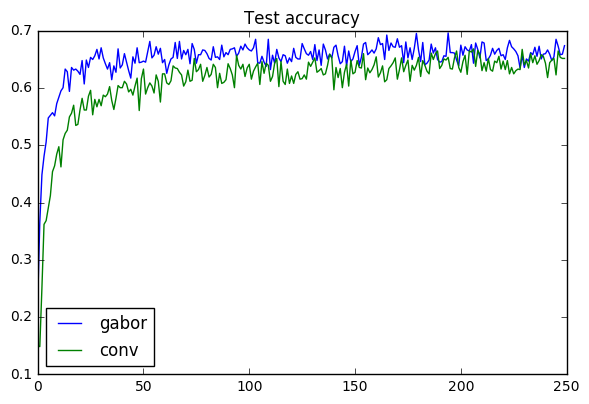

In [20]:
plt.plot(gabor_test_acc, label = 'gabor')
plt.plot(conv_test_acc, label = 'conv')
plt.legend(loc = 0)
plt.tight_layout()
plt.title('Test accuracy')
plt.show()

In [22]:
net.g1.weight.shape[0]

32

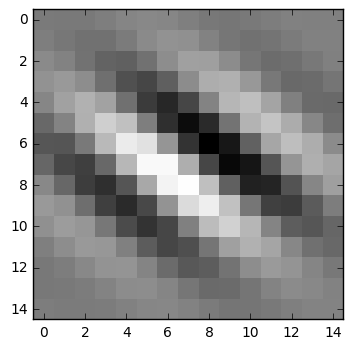

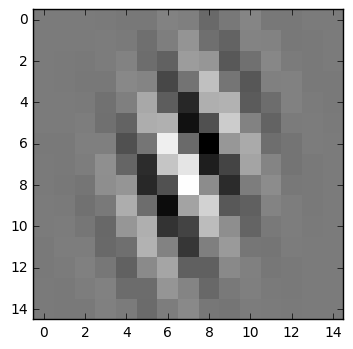

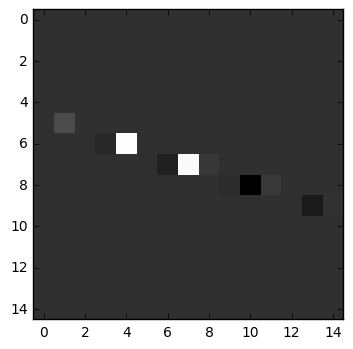

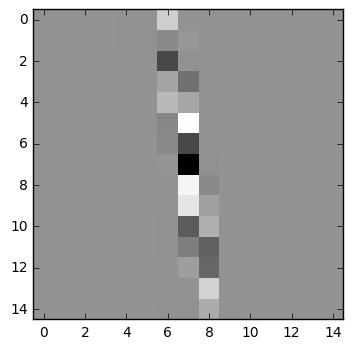

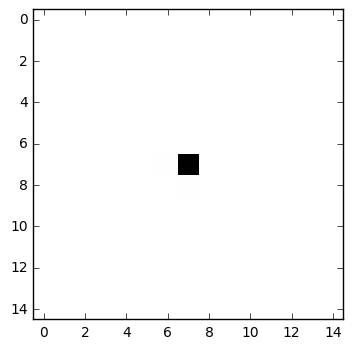

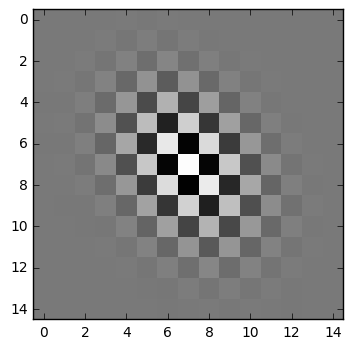

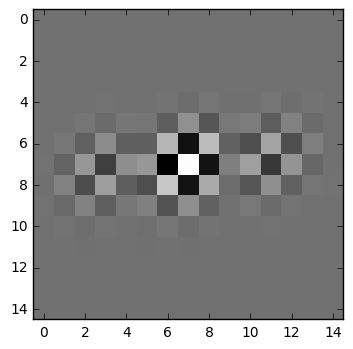

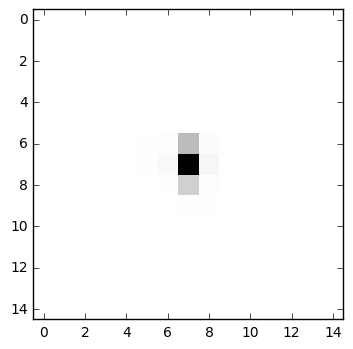

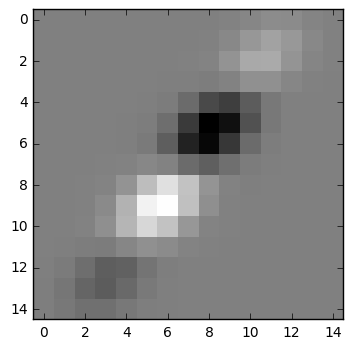

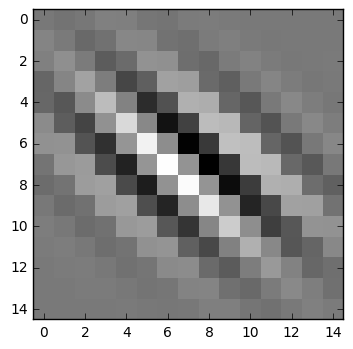

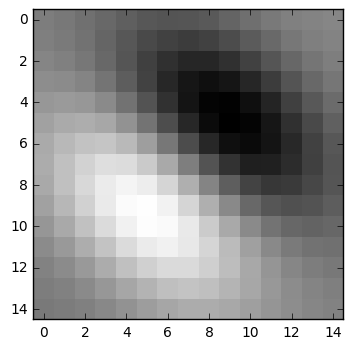

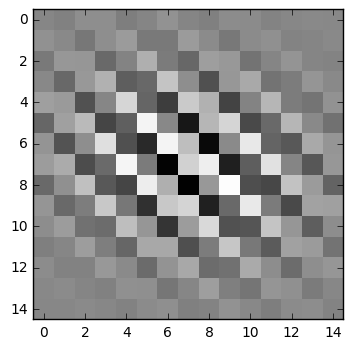

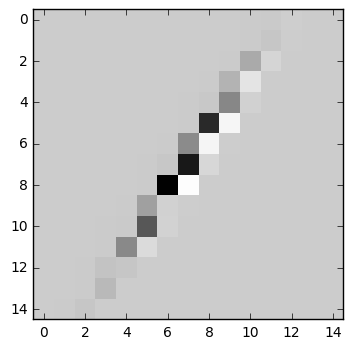

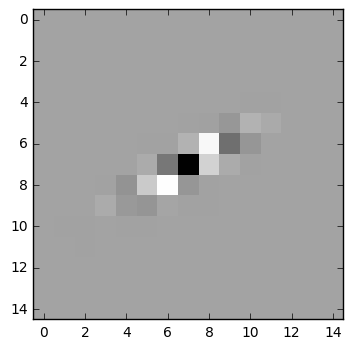

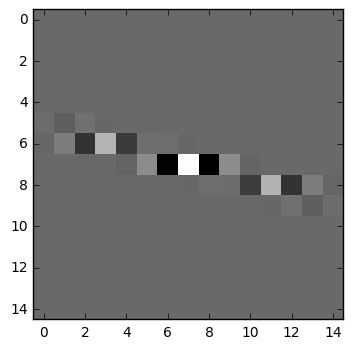

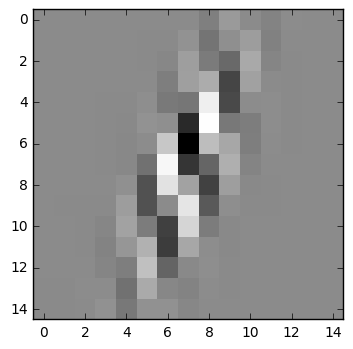

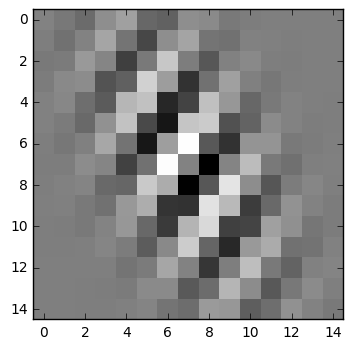

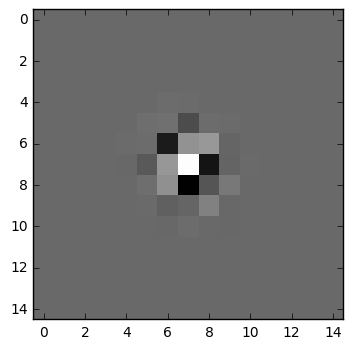

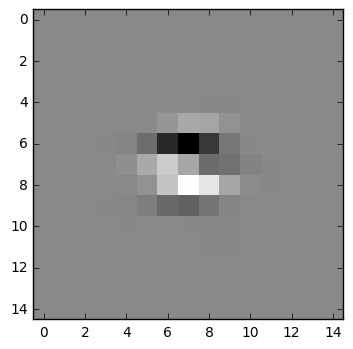

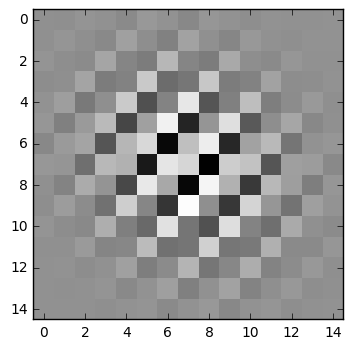

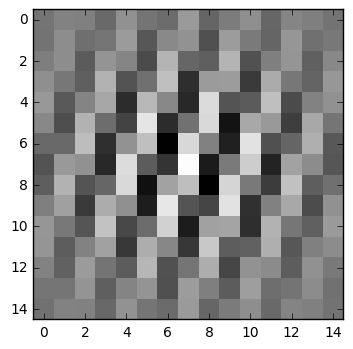

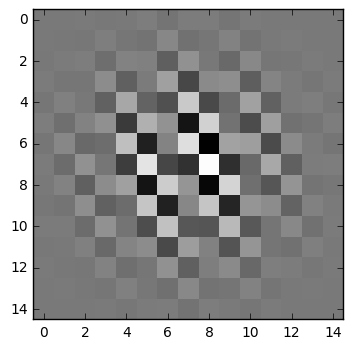

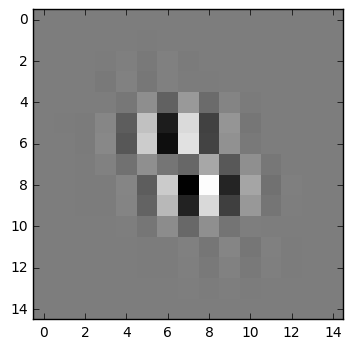

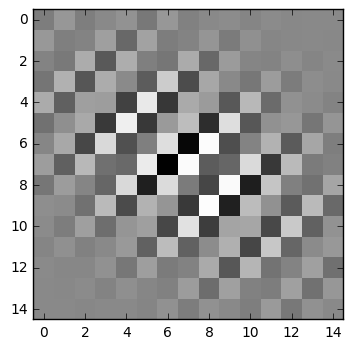

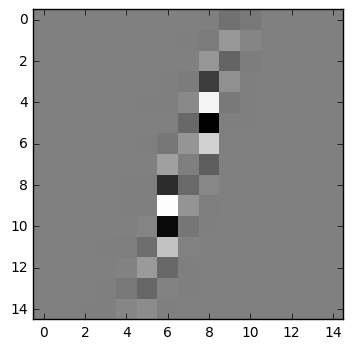

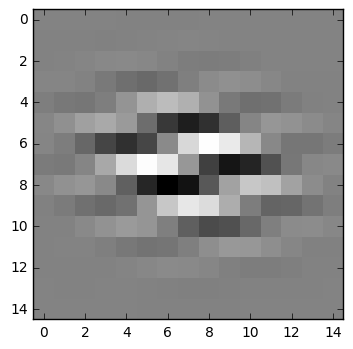

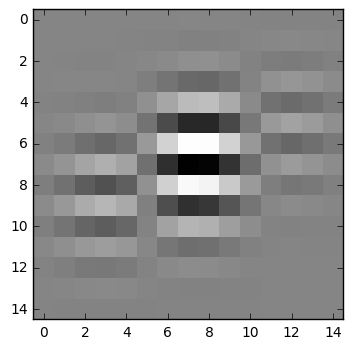

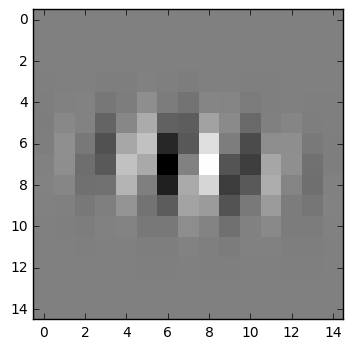

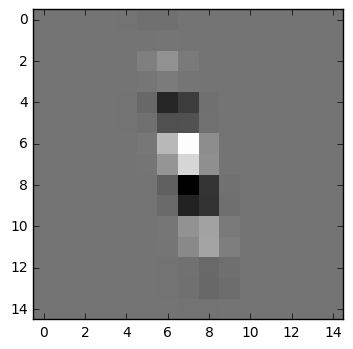

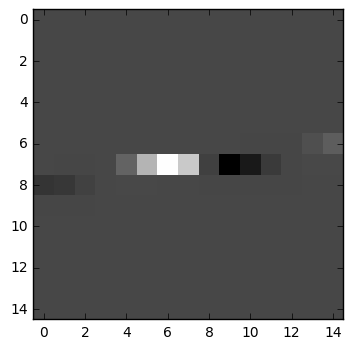

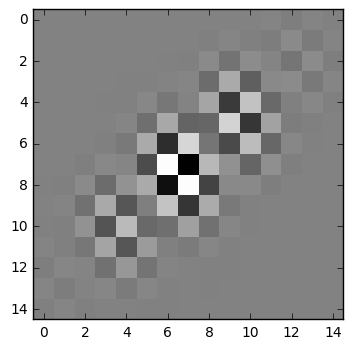

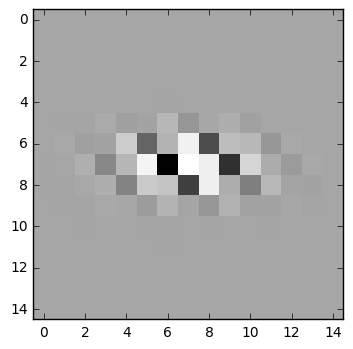

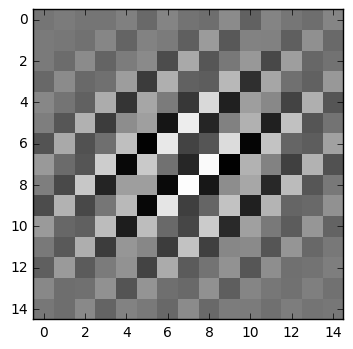

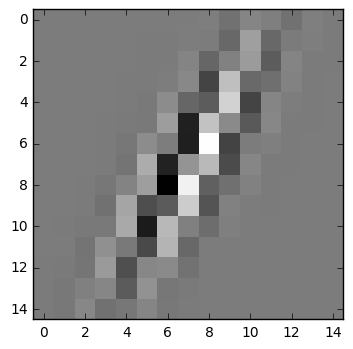

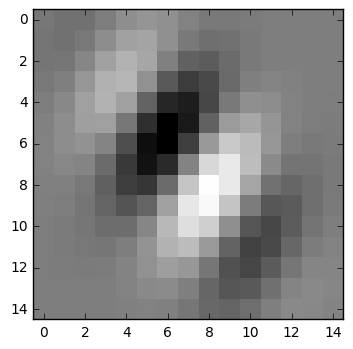

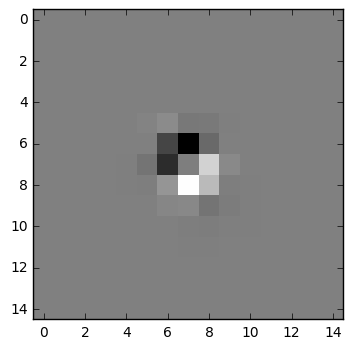

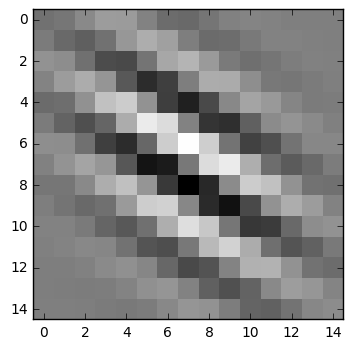

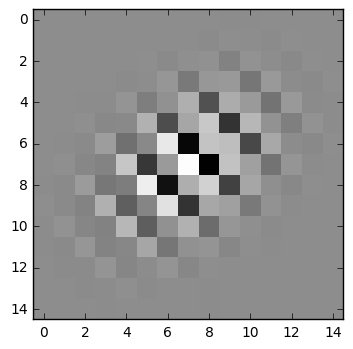

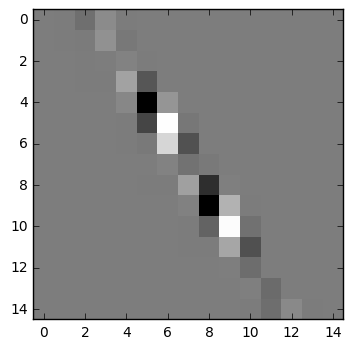

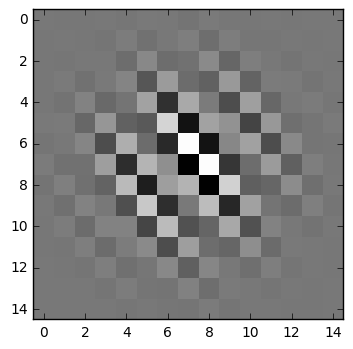

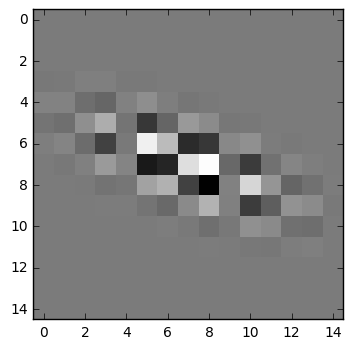

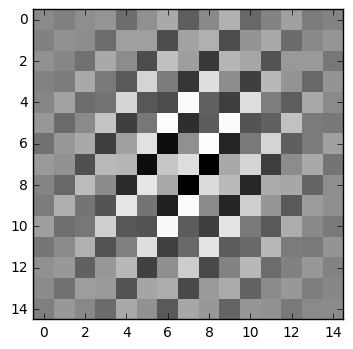

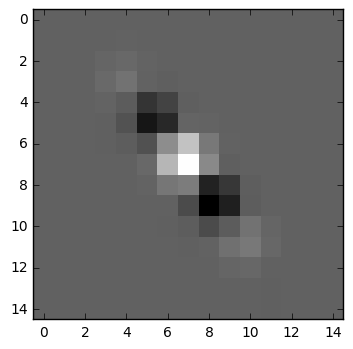

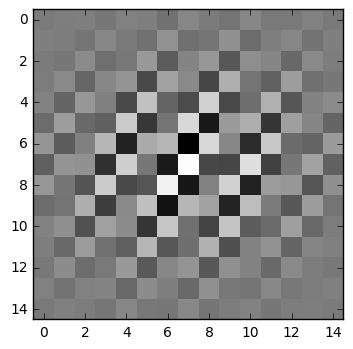

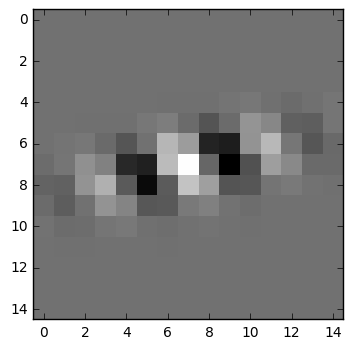

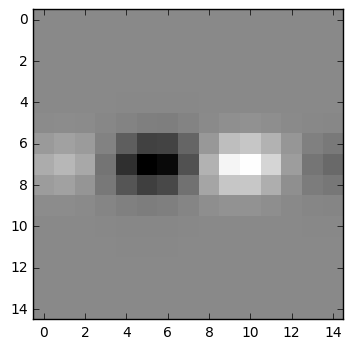

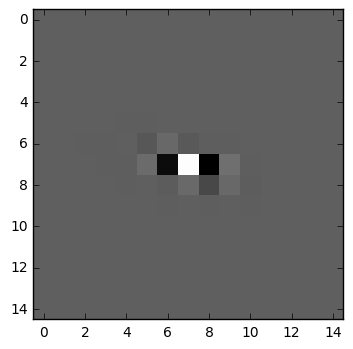

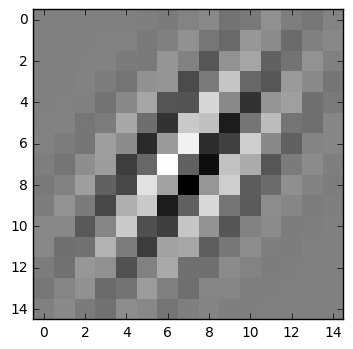

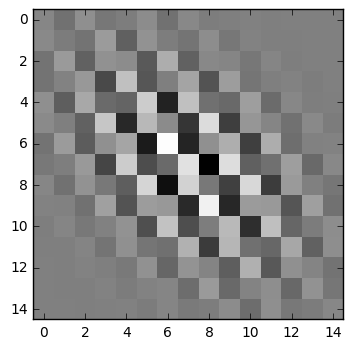

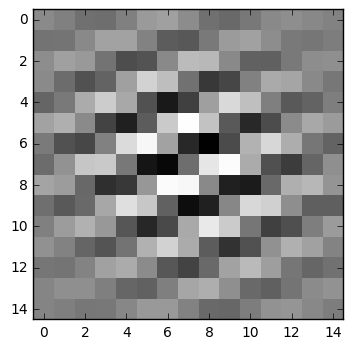

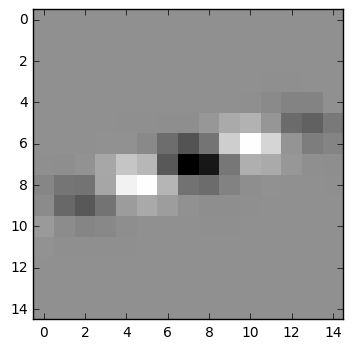

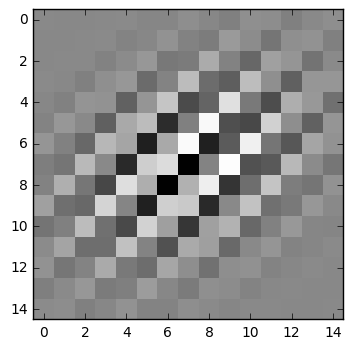

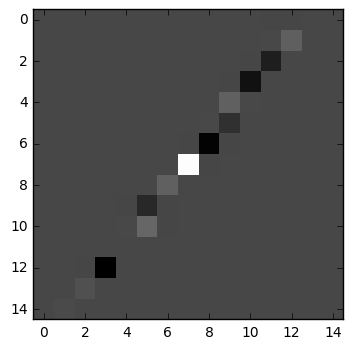

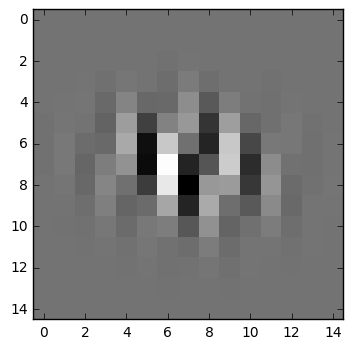

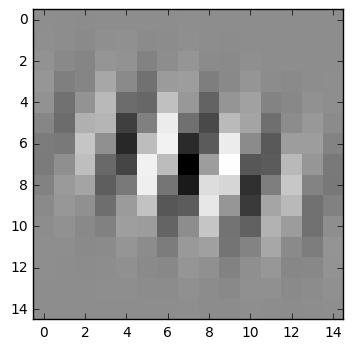

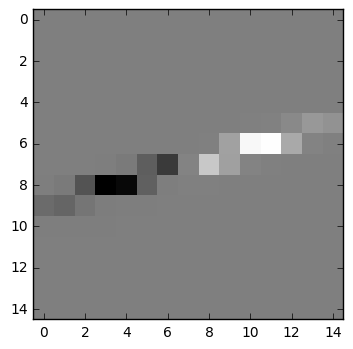

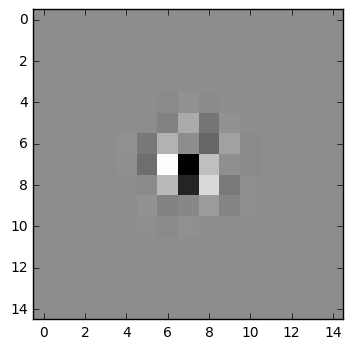

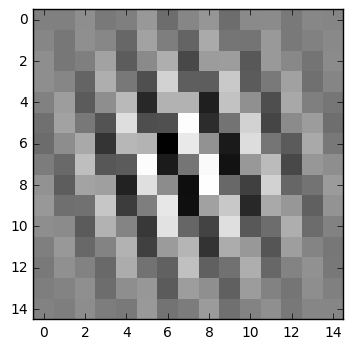

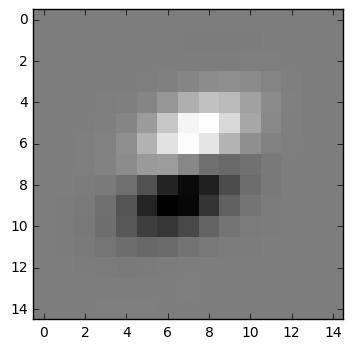

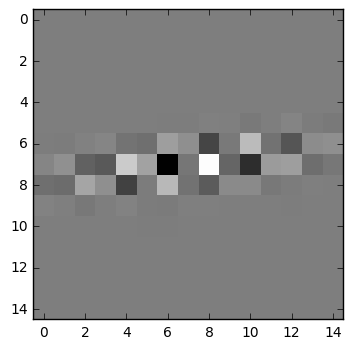

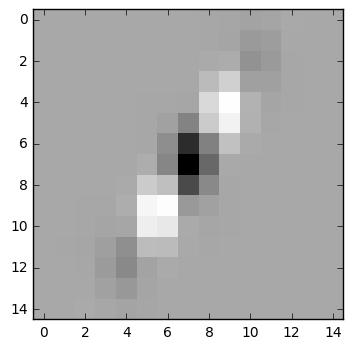

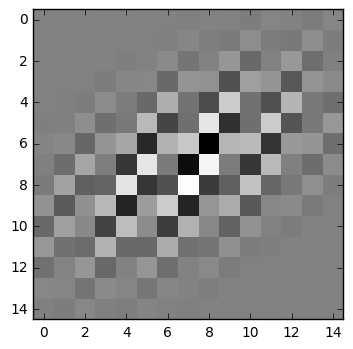

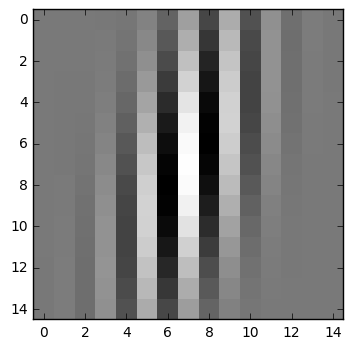

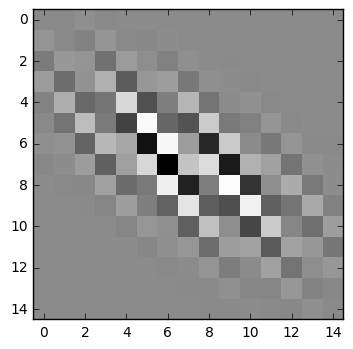

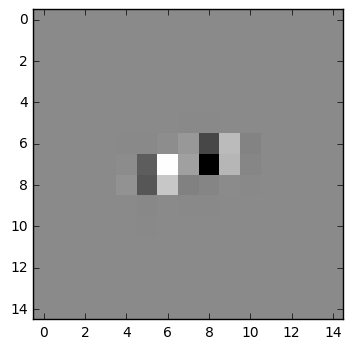

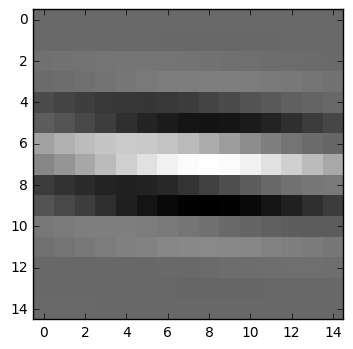

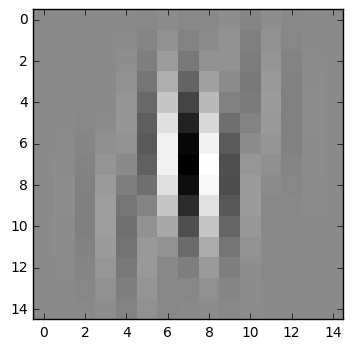

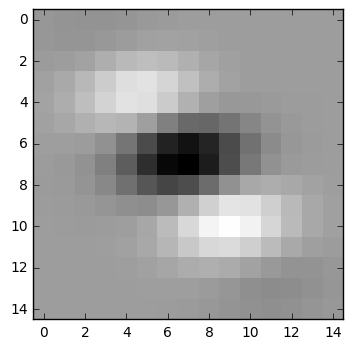

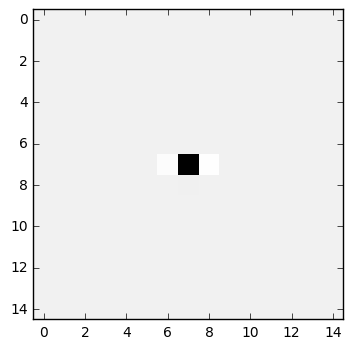

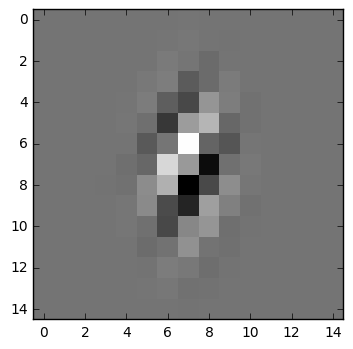

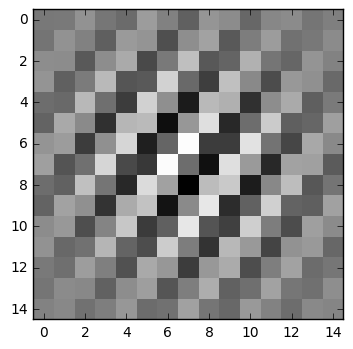

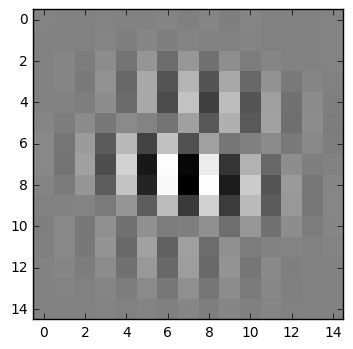

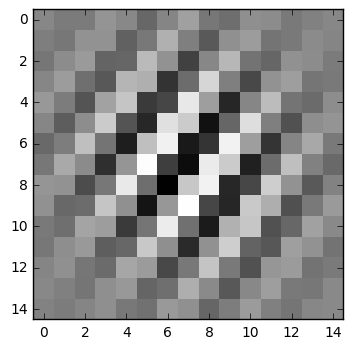

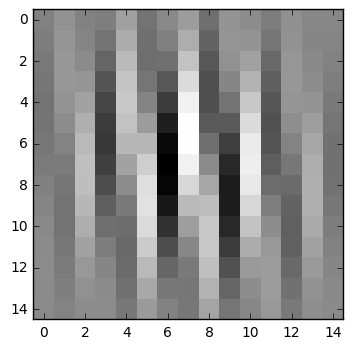

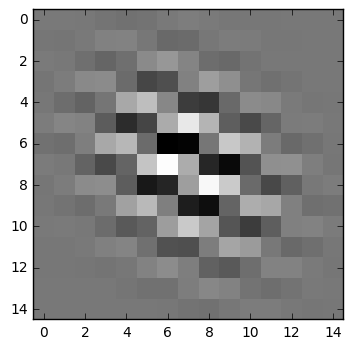

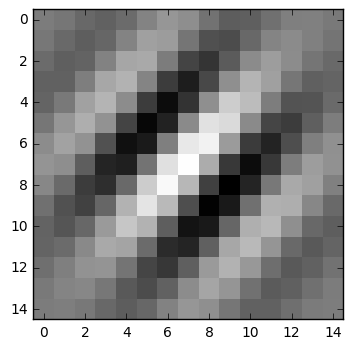

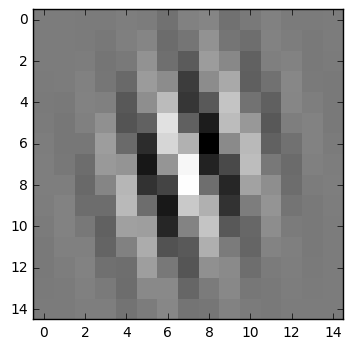

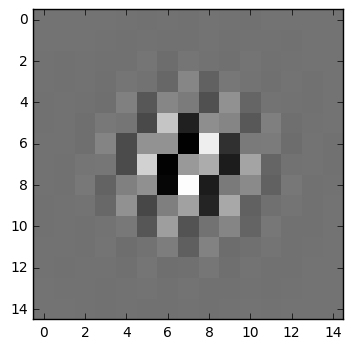

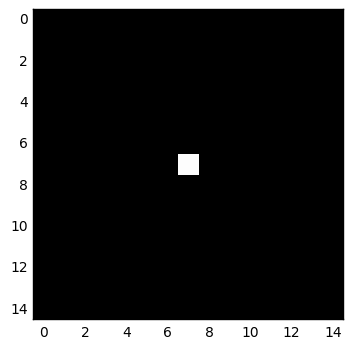

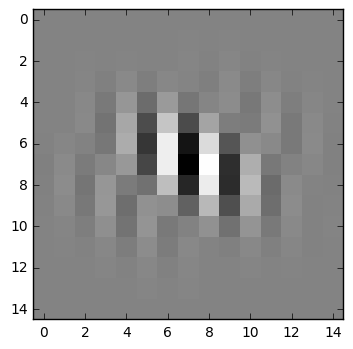

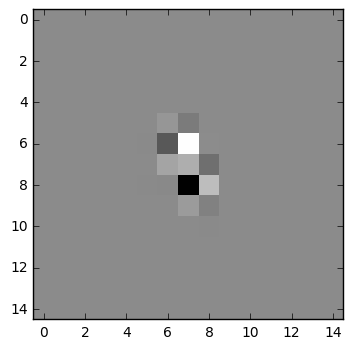

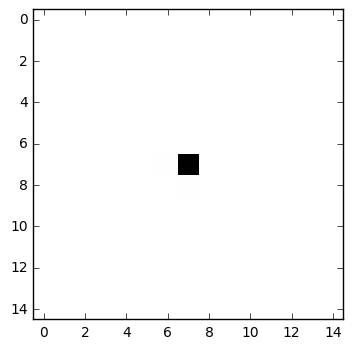

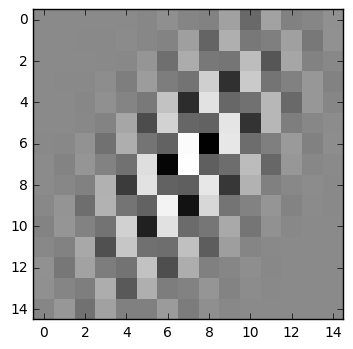

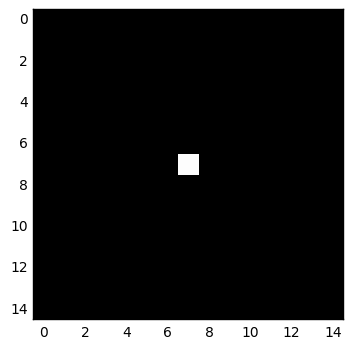

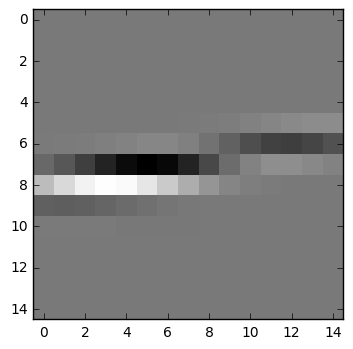

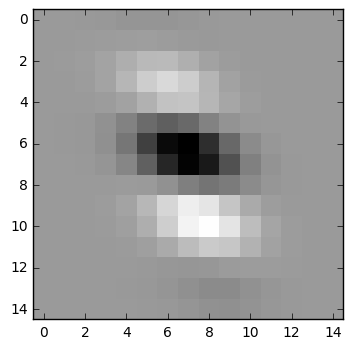

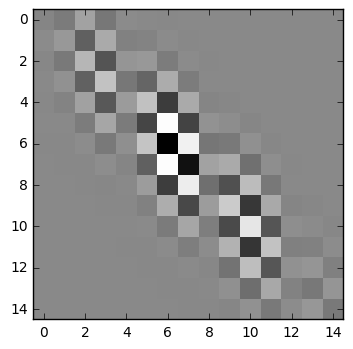

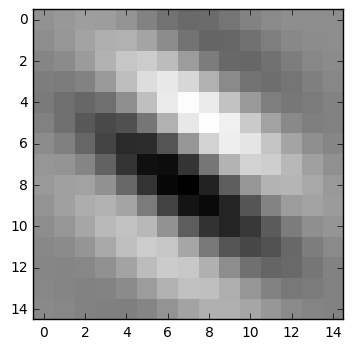

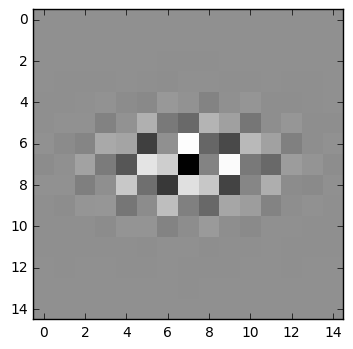

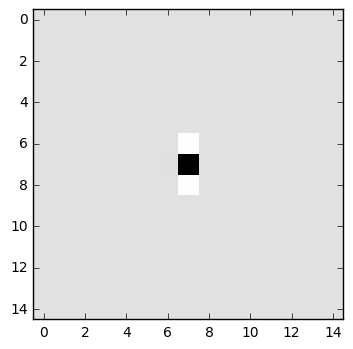

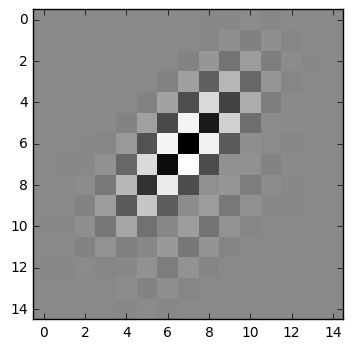

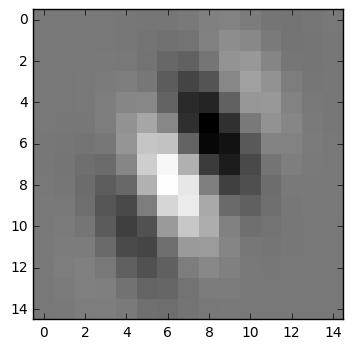

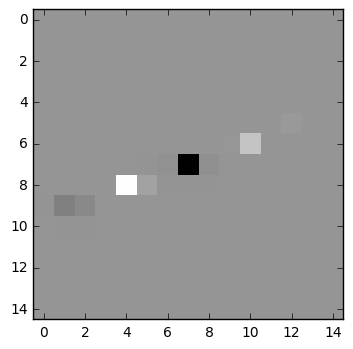

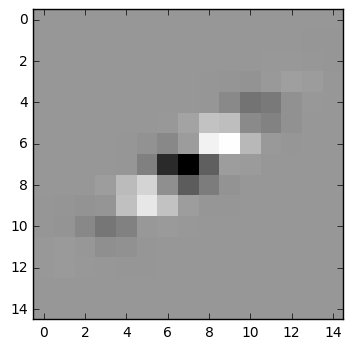

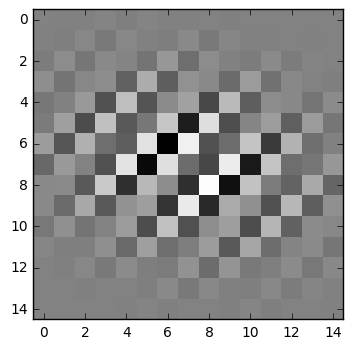

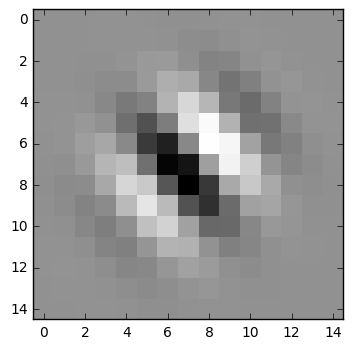

In [28]:
for i in range(net.g1.weight.shape[0]):
    for j in range(net.g1.weight.shape[1]):
        plt.imshow(net.g1.weight[i,j].to('cpu').detach().numpy(), cmap = 'gray', interpolation='none')
        plt.show()

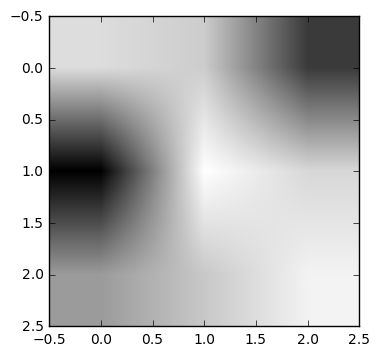

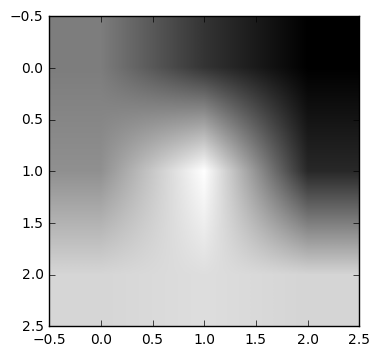

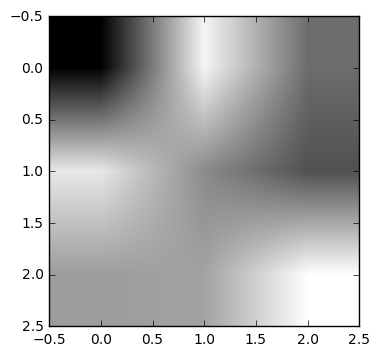

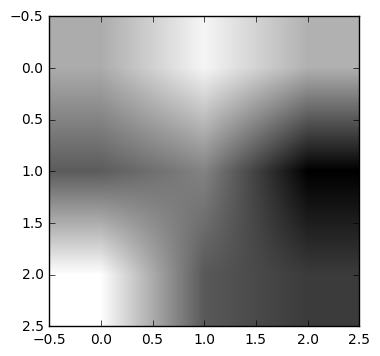

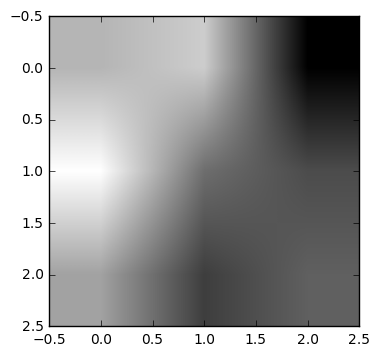

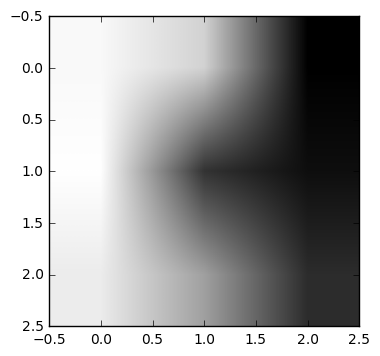

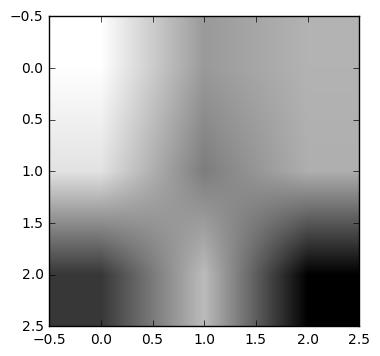

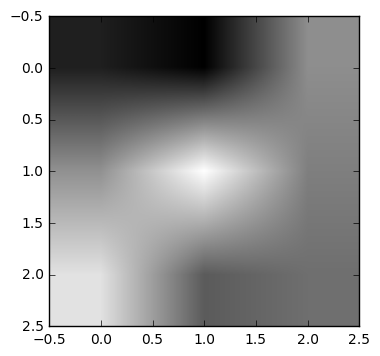

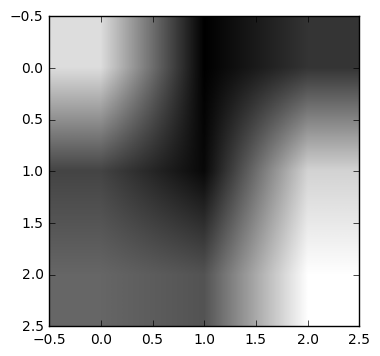

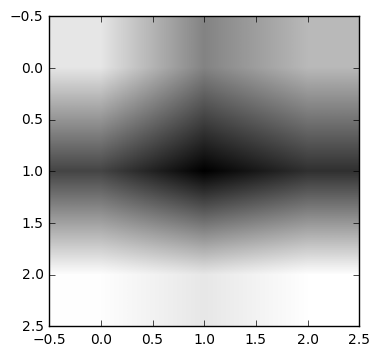

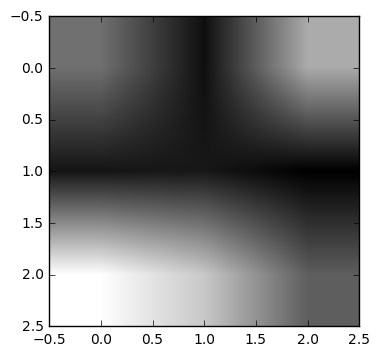

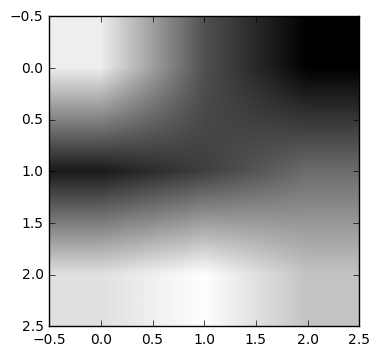

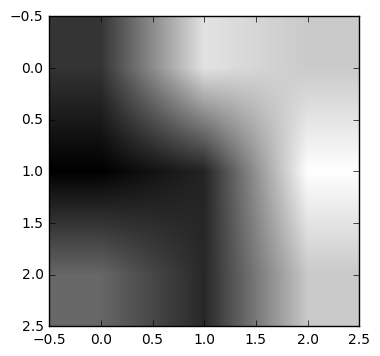

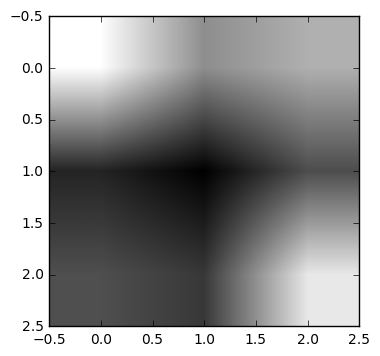

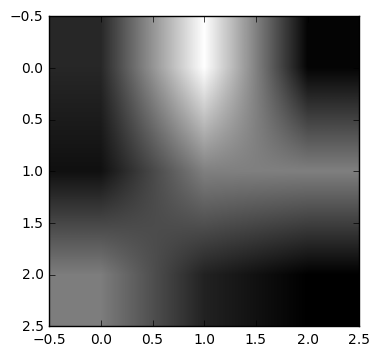

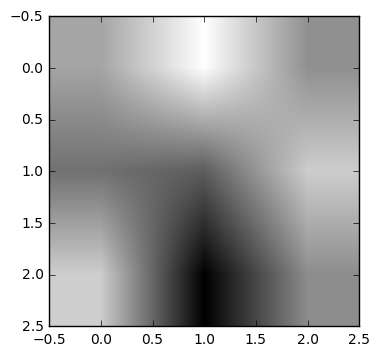

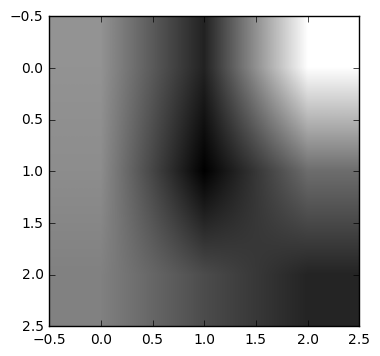

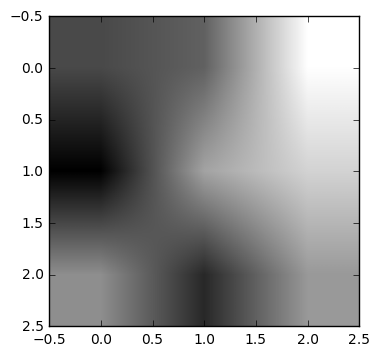

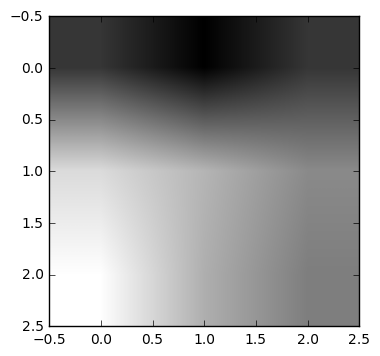

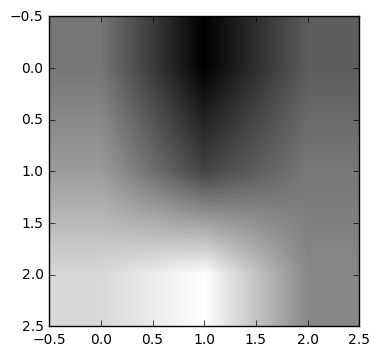

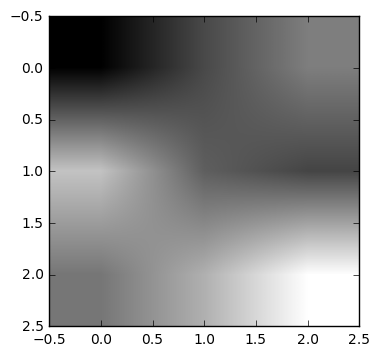

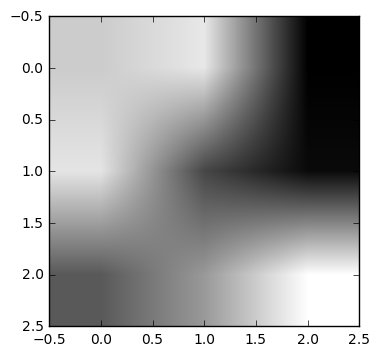

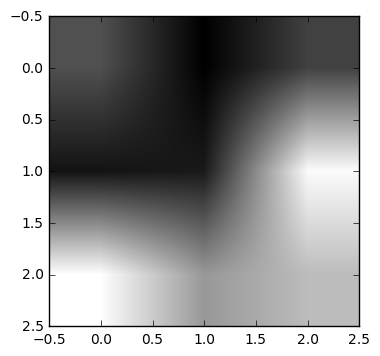

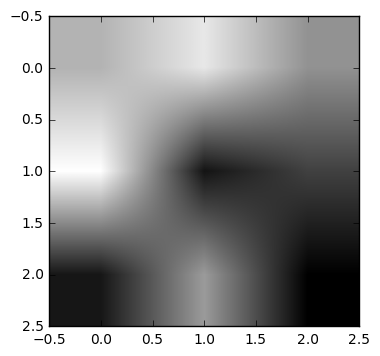

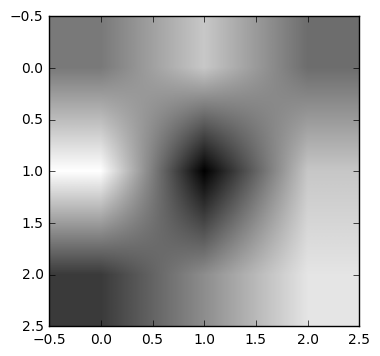

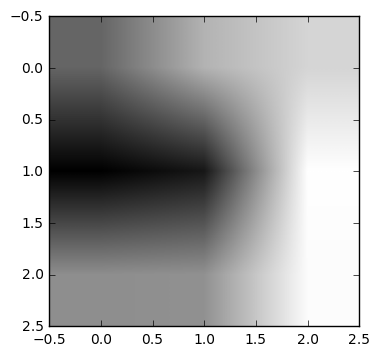

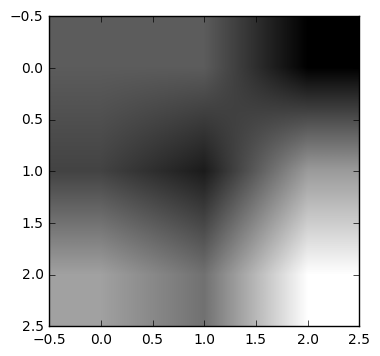

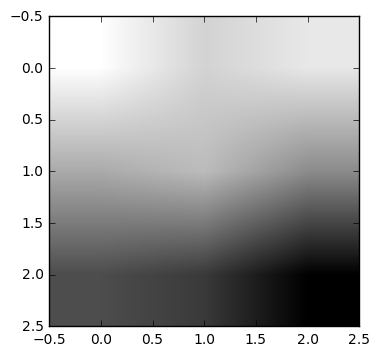

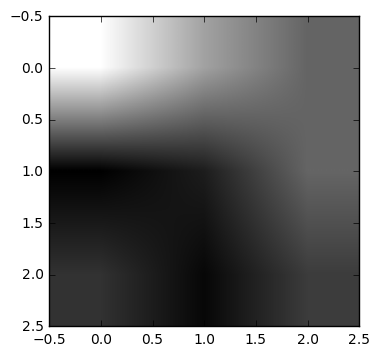

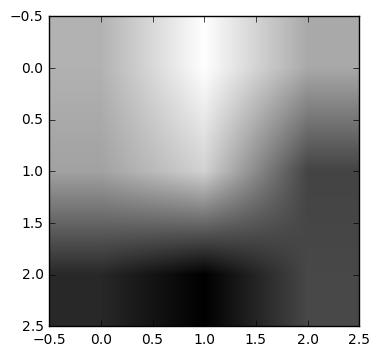

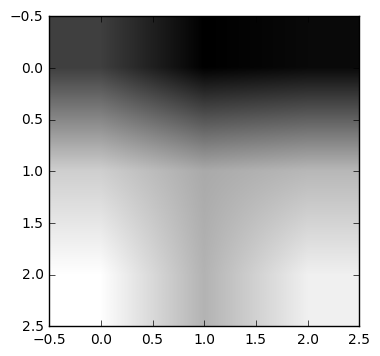

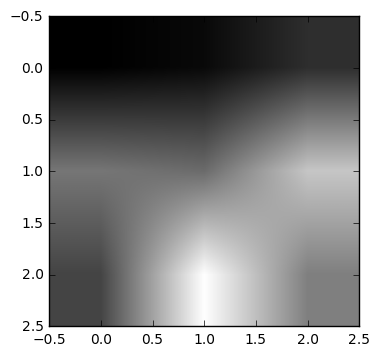

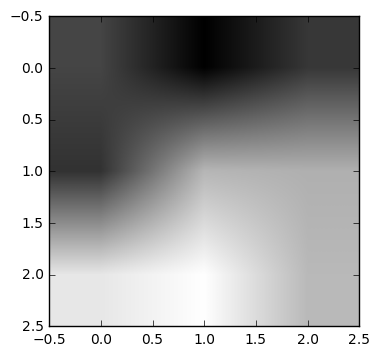

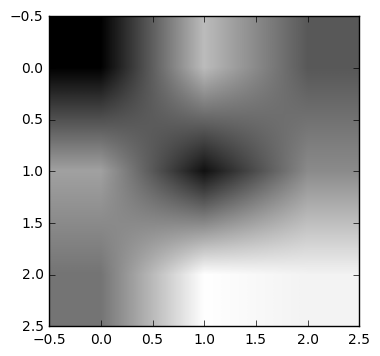

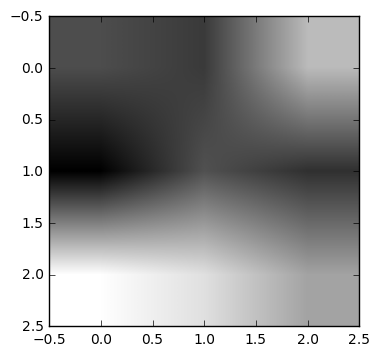

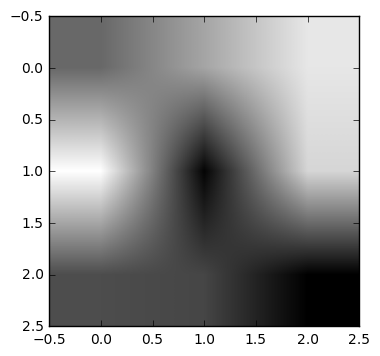

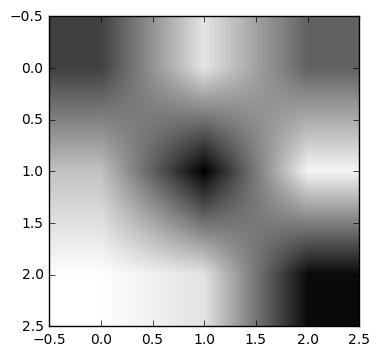

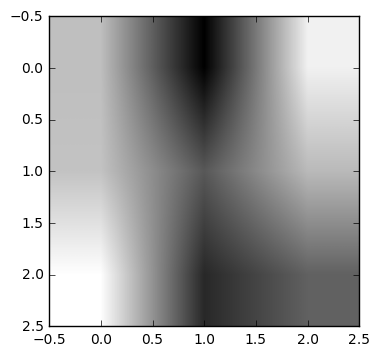

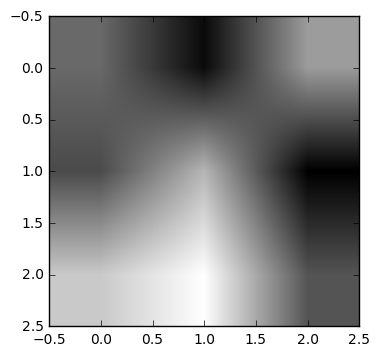

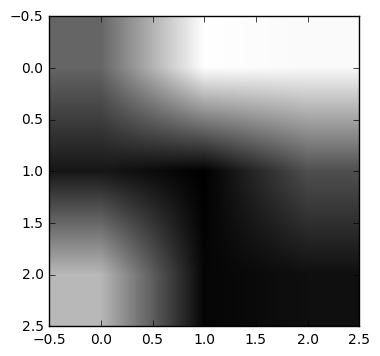

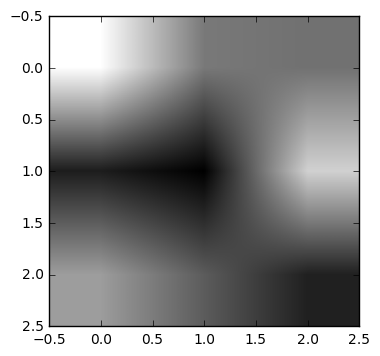

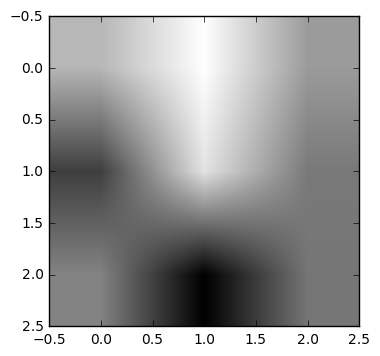

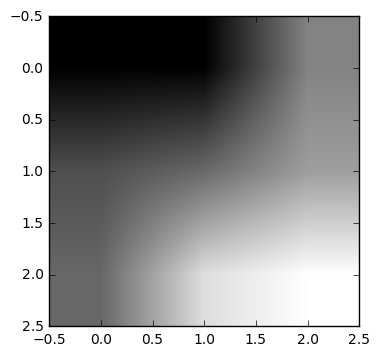

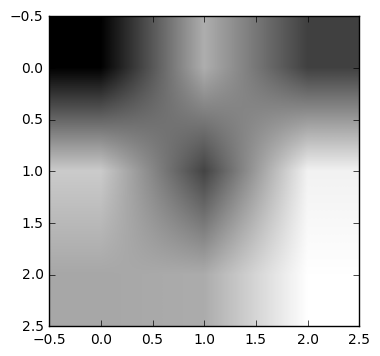

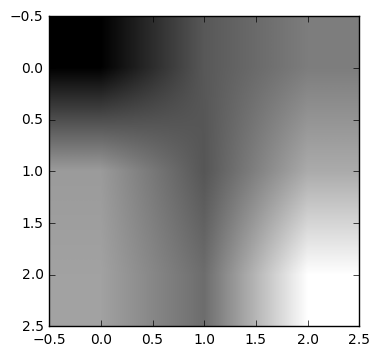

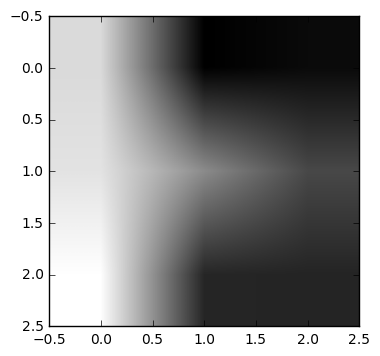

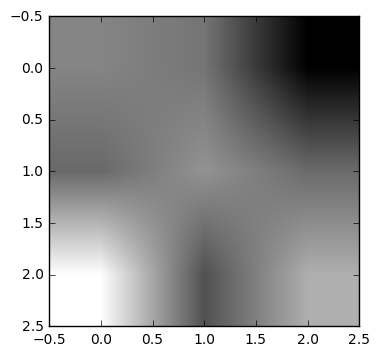

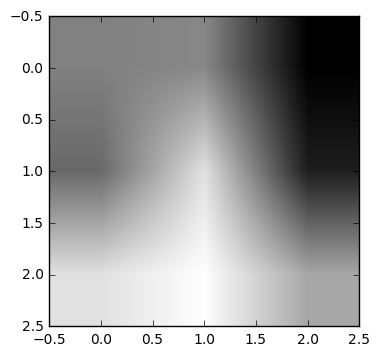

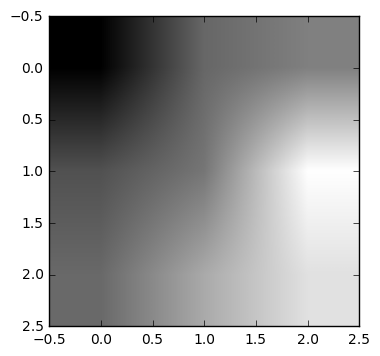

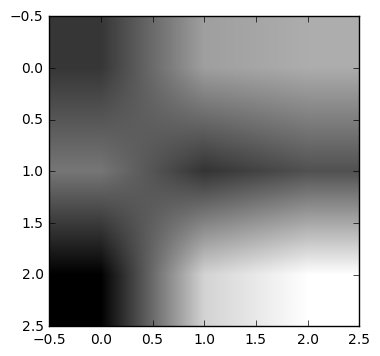

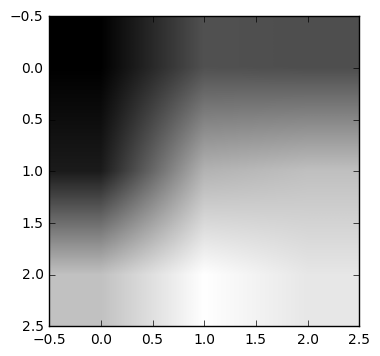

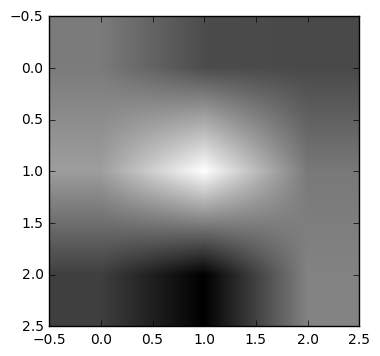

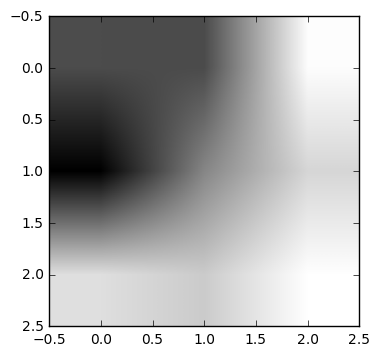

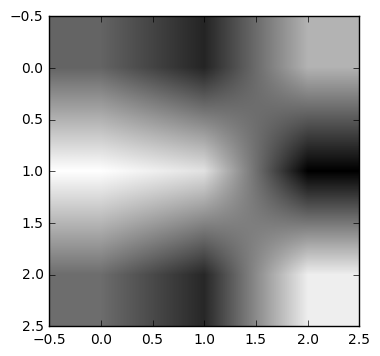

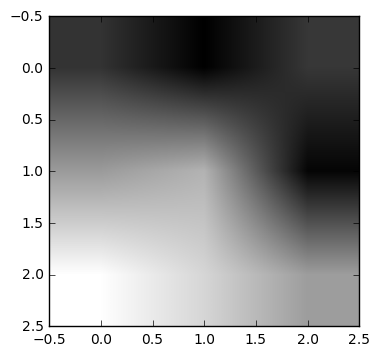

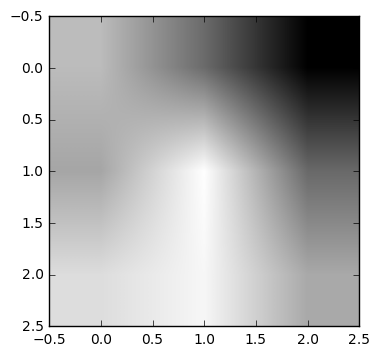

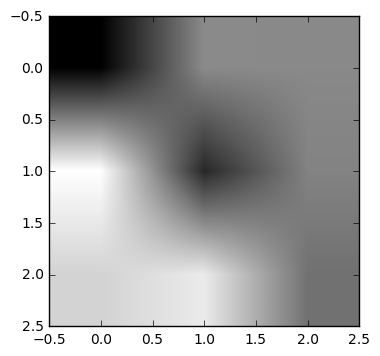

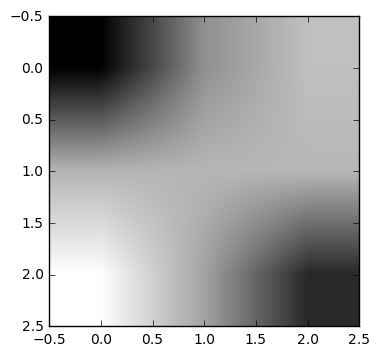

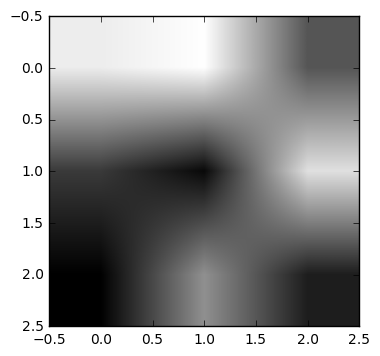

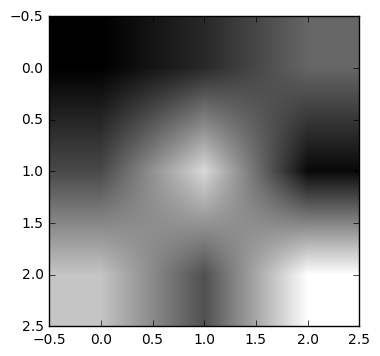

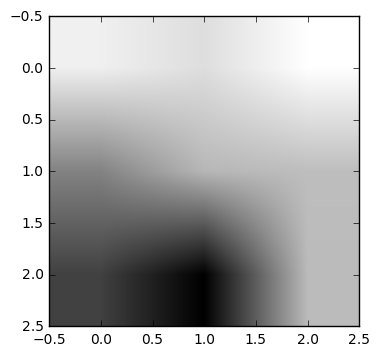

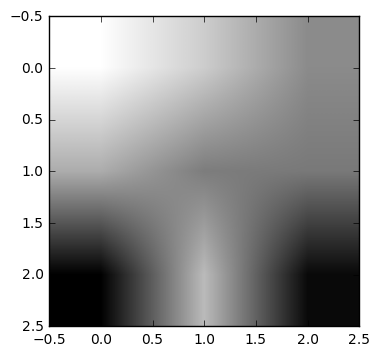

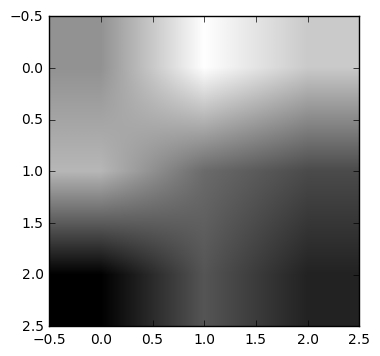

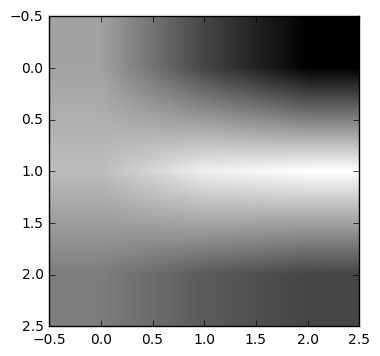

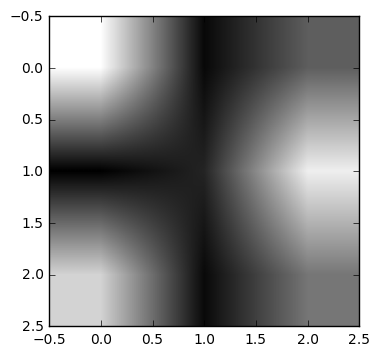

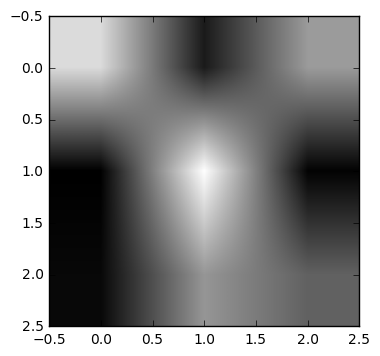

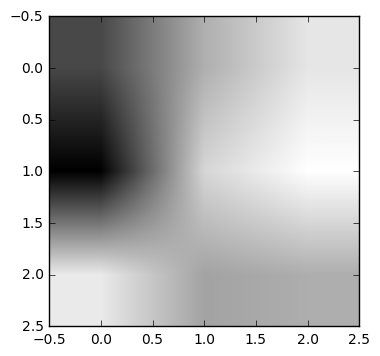

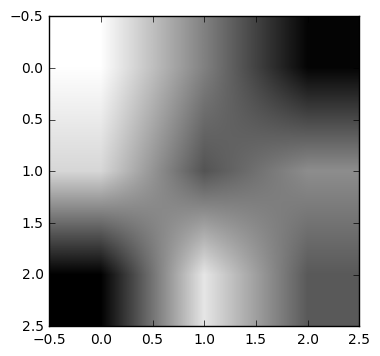

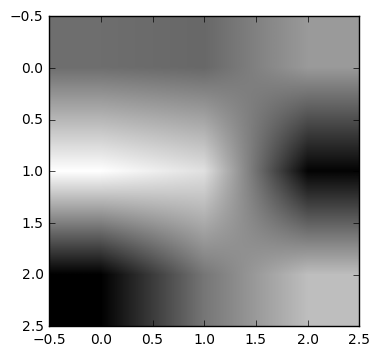

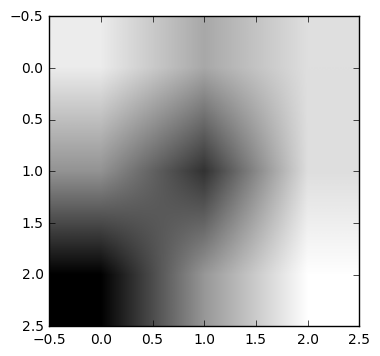

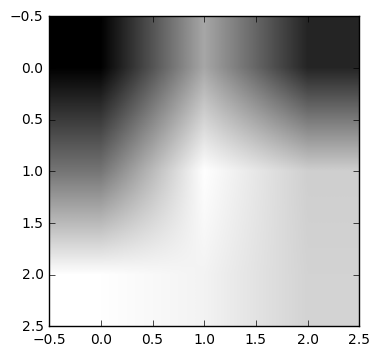

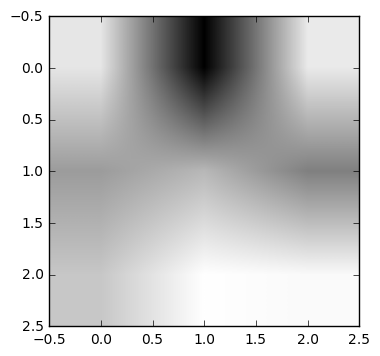

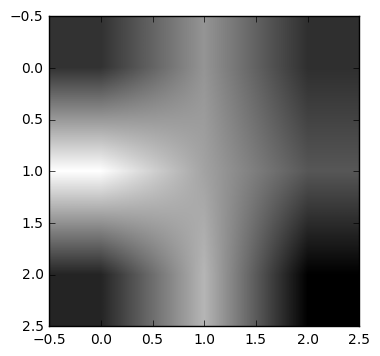

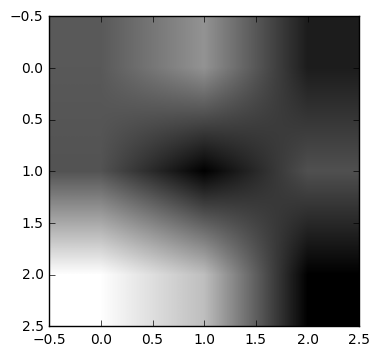

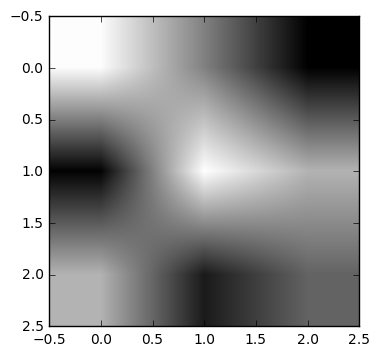

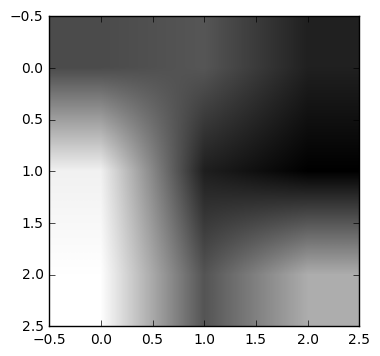

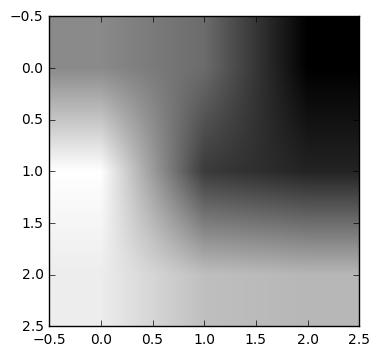

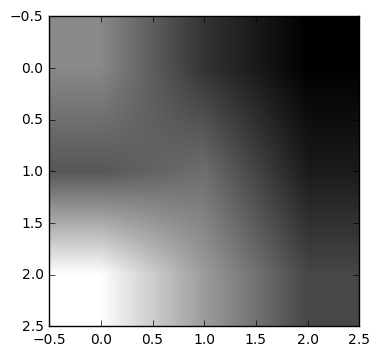

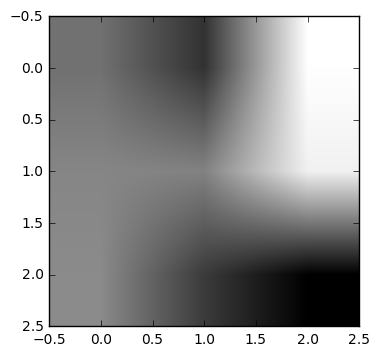

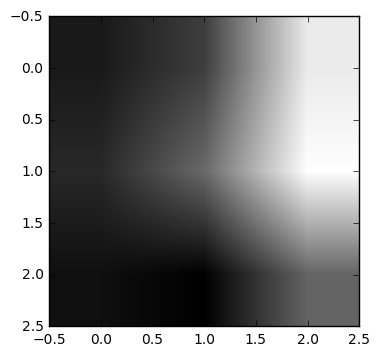

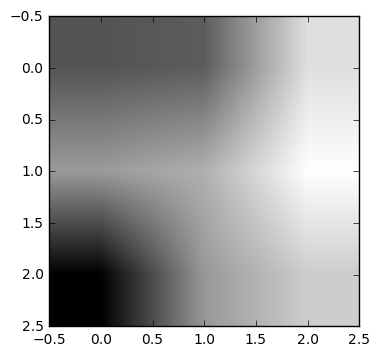

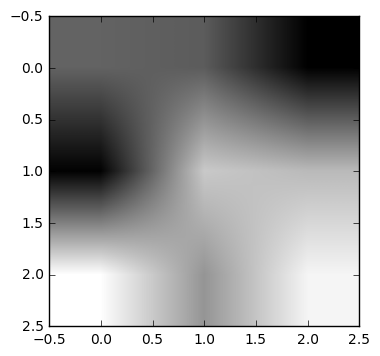

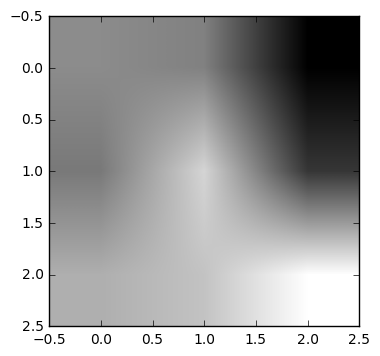

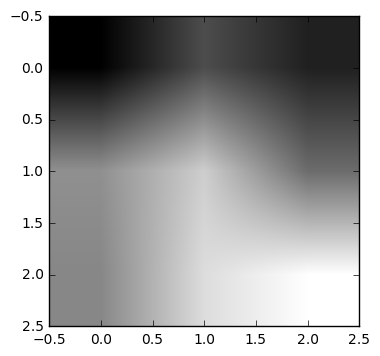

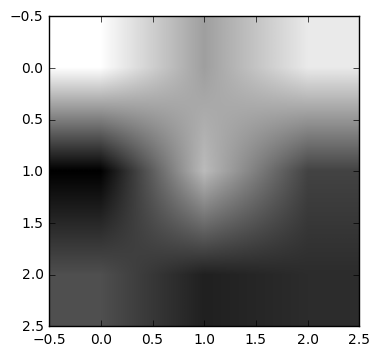

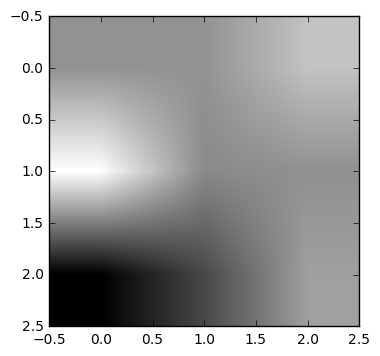

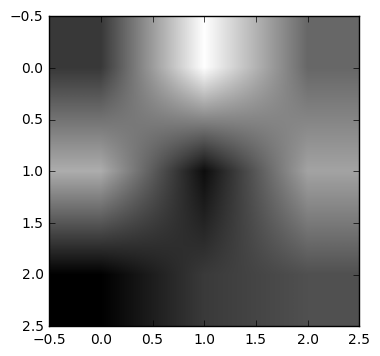

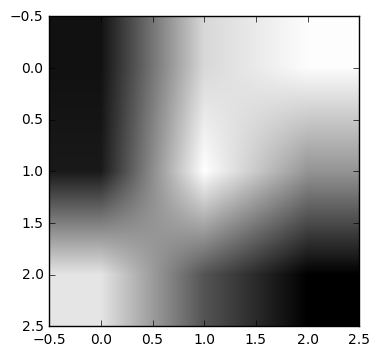

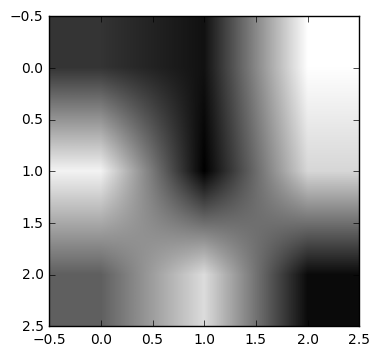

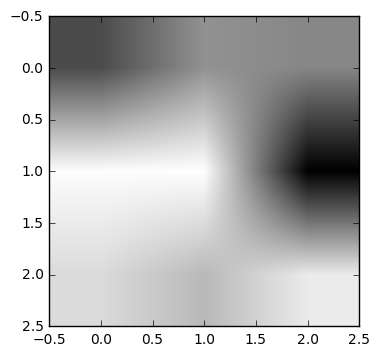

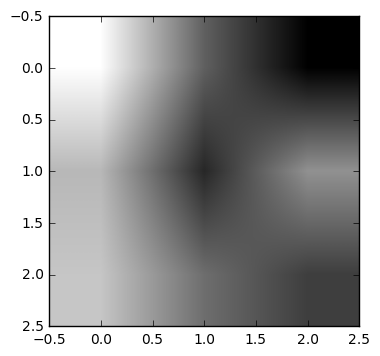

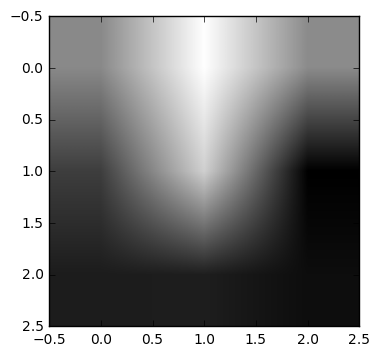

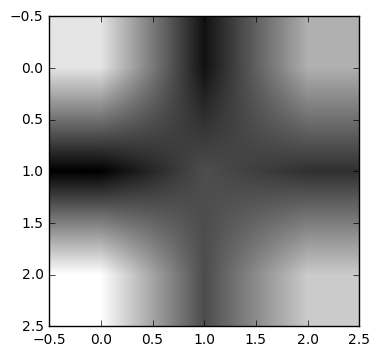

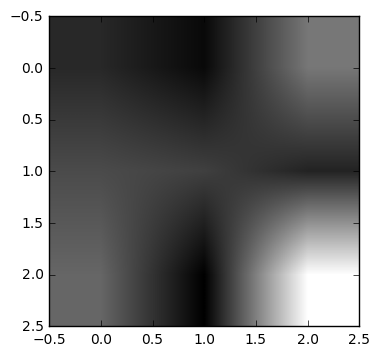

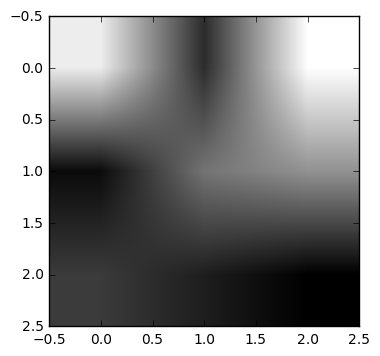

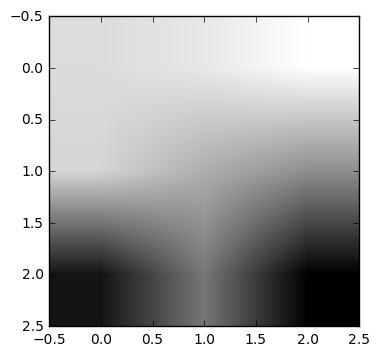

In [29]:
for i in range(conv.c0.weight.shape[0]):
    for j in range(conv.c0.weight.shape[1]):
        plt.imshow(conv.c0.weight[i,j].to('cpu').detach().numpy(), cmap = 'gray')
        plt.show()

## Test GLayer eval.time

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

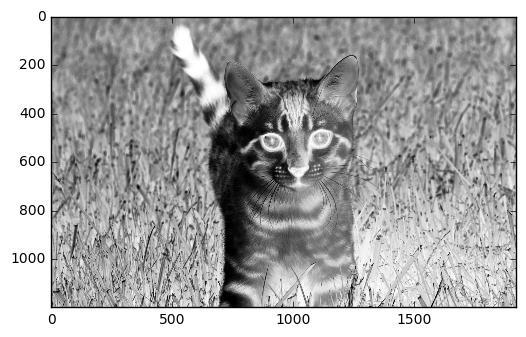

In [33]:
img = cv2.imread('cat.jpg',0)
plt.imshow(img, cmap='Greys')
plt.show()

In [34]:
img = torch.tensor(img).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)

In [35]:
GLayer = MyGabor(1,1, kernel_size=(15,15)).to(device)
CLayer = nn.Conv2d(1,1, kernel_size=(15,15)).to(device)

In [44]:
%timeit -r 100 x = GLayer(img.to(device))

100 loops, best of 100: 7.19 ms per loop


In [45]:
%timeit -r 100 x = CLayer(img.to(device))

100 loops, best of 100: 5.37 ms per loop
